In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils import data as data_
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets
import torchvision
import gzip


In [2]:
# full_dataset = datasets.MNIST(root='data',train=True,download=True)

In [3]:
class MNISTDataset(Dataset):
  def __init__(self, data_file, label_file, transform=None):
    self.transform=transform

    with gzip.open(data_file, 'rb') as f:
      self.images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28,28)

    with gzip.open(label_file, 'rb') as f:
      self.images = np.frombuffer(f.read(), np.uint8, offset=8)
  
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.images[idx]

    image = np.reshape(image,(28,28))
    image = np.resize(image, (224,224))

    if self.transform:
      image = self.transform(image)

    return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),  # 調整圖片大小
    transforms.ToTensor(),  # 轉換成 Tensor 格式
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
train_data = torchvision.datasets.MNIST(root = './mnist',train = True,transform = transform ,download = True)

train_size = len(train_data)
valid_size = int(0.3 * train_size)  # 20% 的資料作為驗證集

# 使用random_split切分資料集
train_dataset, valid_dataset = random_split(train_data, [train_size - valid_size, valid_size])

train_loader = data_.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True,num_workers = 8)
valid_loader  = data_.DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle = True,num_workers = 8)

test_data = torchvision.datasets.MNIST(root = './mnist/', train = False,transform = transform)
test_loader = data_.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True,num_workers = 8)
# test_x = torch.unsqueeze(test_data.test_data, dim = 1).type(torch.FloatTensor)[:2000]/255.
# test_y = test_data.test_labels[:2000]


In [5]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_output_size = self._get_conv_output_size((1, 224, 224))

        self.classifier = nn.Sequential(
            nn.Linear(self.conv_output_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # 新增一個全連接層
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # 修改為 num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _get_conv_output_size(self, shape):
        x = torch.rand(1, *shape)
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x.size(1)


In [6]:
import torchvision.models as models

# model = models.vgg11(pretrained=True)
# print(model.features[0])
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = LeNet5(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# summary(model, (1, 224, 224))  # 此處的(3, 128, 128)是你期望的輸入圖像的形狀

In [7]:
#Model Training
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [8]:
#A Function to Predict Test Data
def predict_data(model, data):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(data):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            test_preds_label = torch.argmax(test_preds, dim=1)
            num_correct += torch.sum(test_preds_label == y_test)
            num_samples += len(y_test)
        
    # model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [9]:
from torch.backends import cudnn
cudnn.benchmark = True # fast training

#The Training Loop
train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []
num_epochs = 20

for epoch in range(num_epochs):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        

        optimizer.zero_grad()
        # Forward propagation
        train_preds = model(X_train)        
        train_loss = loss_function(train_preds, y_train)
        
        # # Calculate train accuracy
        
            
        # Backward propagation
        # optimizer.zero_grad()   
        train_loss.backward()        
        # Gradient descent
        optimizer.step()        

        # with torch.no_grad():
        train_preds_label = torch.argmax(train_preds, dim=1)       
        num_correct_train += torch.sum(train_preds_label == y_train)
        num_samples_train += len(y_train)
        
    scheduler.step()
    # print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_data(model, valid_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch+1} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Valid loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Valid acc: {np.round(test_acc.item(),2)} \t|' \
            f' Learning Rate: {optimizer.param_groups[0]["lr"]}' )

100%|██████████| 329/329 [00:56<00:00,  5.78it/s]


Epoch: 1 	| Train loss: 0.791 	| Valid loss: 0.101 	| Train acc: 0.82 	| Valid acc: 0.97 	| Learning Rate: 0.045000000000000005


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 2 	| Train loss: 0.42 	| Valid loss: 0.032 	| Train acc: 0.98 	| Valid acc: 0.98 	| Learning Rate: 0.04050000000000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 3 	| Train loss: 0.1 	| Valid loss: 0.07 	| Train acc: 0.99 	| Valid acc: 0.99 	| Learning Rate: 0.03645000000000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 4 	| Train loss: 0.002 	| Valid loss: 0.039 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.03280500000000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 5 	| Train loss: 0.0 	| Valid loss: 0.029 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.02952450000000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 6 	| Train loss: 0.0 	| Valid loss: 0.087 	| Train acc: 1.0 	| Valid acc: 0.98 	| Learning Rate: 0.02657205000000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 7 	| Train loss: 0.0 	| Valid loss: 0.212 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.02391484500000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 8 	| Train loss: 0.0 	| Valid loss: 0.001 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.021523360500000012


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 9 	| Train loss: 0.0 	| Valid loss: 0.042 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.01937102445000001


100%|██████████| 329/329 [00:53<00:00,  6.20it/s]


Epoch: 10 	| Train loss: 0.0 	| Valid loss: 0.038 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.01743392200500001


100%|██████████| 329/329 [00:53<00:00,  6.19it/s]


Epoch: 11 	| Train loss: 0.0 	| Valid loss: 0.059 	| Train acc: 1.0 	| Valid acc: 0.99 	| Learning Rate: 0.015690529804500006


 16%|█▌        | 53/329 [00:08<00:44,  6.16it/s]


KeyboardInterrupt: 

range(1, 11)


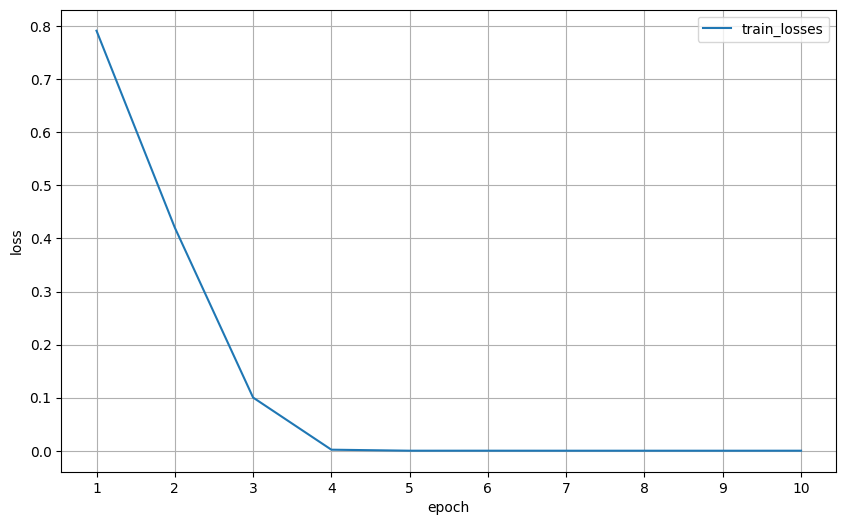

In [12]:
#Evaluation
plt.figure(figsize=(10,6))
plt.grid()
epochs = range(1, len(train_losses))
print(epochs)
plt.plot(epochs,train_losses[:10])
# plt.plot(epochs,test_losses)
plt.legend(['train_losses', 'valid_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(epochs)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
# model = torch.load('path_to_your_best_LeNet.pth')
model.eval()
accuracy = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100* correct / total
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 98.95%
